In [1]:
import numpy as np
from scipy.constants import c, Boltzmann
from scipy.optimize import minimize
#from scipy.optimize import differential_evolution
#from scipy import signal

#import pickle
#import sympy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm


from scipy.sparse import csr_matrix
from joblib import Parallel, delayed

In [2]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

c:\Users\rasmu\Documents\GitHub\MMARS


In [3]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]))

## Setting up the target

In [4]:
target_model_1 = mmars.Target(start_position=np.array([[5.001,5.001]]), start_velocity=5., T_total=15., T_frame=0.1)
target_model_1.generate_trajectory(trajectory_type="sinusoidal")
target_ground_truth = target_model_1.get_trajectory()

In [5]:
simulation_data = mmars.Simulation(radar_model_1, target_model_1)
simulation_data.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x00000182C7DAC950> and <mmars.target.Target object at 0x00000182C89E1510>


 47%|████▋     | 70/150 [00:10<00:12,  6.56it/s]


KeyboardInterrupt: 

In [ ]:
sim_data = simulation_data.get_data()

In [ ]:
wavelength = c/77e9

def generate_S_signal(
                    target_x, 
                    target_y, 
                    position=np.array([[0,0]]),
                    tx_antennas = np.array(([-12*(wavelength/2), 0],
                                           [-8*(wavelength/2), 0],
                                           [-4*(wavelength/2), 0])),
                    rx_antennas = np.array(([-(3/2)*(wavelength/2), 0],
                                    [-(1/2)*(wavelength/2), 0],
                                    [(1/2)*(wavelength/2), 0],
                                    [(3/2)*(wavelength/2), 0])),
                    chirp_Rate = 30e6/1e-6, 
                    T_chirp = 25.66e-6,
                    transmitPower = 1,
                    gain = 1,
                    radarCrossSection = 1,
                    f_sampling = 20e6,
                    N_samples = 256,
                    N_chirps = 1,
                    wavelength = c/77e9
                    ):
        
    S_signal = np.zeros((tx_antennas.shape[0] * rx_antennas.shape[0] * N_samples),dtype=complex)
    target_position = np.array([target_x, target_y])

    # Compute the radial distance to the target
    radial_distance = np.linalg.norm(position - target_position, axis=1)


    # Compute all distances between TX and RX antennas and the target
    distances = np.zeros((len(tx_antennas), len(rx_antennas)))
    for tx_idx in range(len(tx_antennas)):
        for rx_idx in range(len(rx_antennas)):
            distances[tx_idx,rx_idx] = np.linalg.norm(tx_antennas[tx_idx] - target_position) + np.linalg.norm(rx_antennas[rx_idx] - target_position)

    # Compute the phase difference between the antennas
    phase_diff_TX_RX = 2*np.pi*distances/wavelength
    phase_diff_TX_RX -= phase_diff_TX_RX[0,0]

    # Compute the Intermediate frequency (IF) frequency:
    sweepBandwidth = chirp_Rate*T_chirp
    f_IF = (2*radial_distance*sweepBandwidth)/(c*T_chirp) 

    # Compute the received power:
    received_power = transmitPower*gain*wavelength**2*radarCrossSection/( (4*np.pi)**3 * radial_distance**4)
    
    # Generate the IF signal
    freqs = np.linspace(0,2 * np.pi, N_samples)[np.newaxis]  # Time variable running from 0 to N_samples/F_sampling
    #time = np.linspace(0, N_samples/f_sampling, N_samples)[np.newaxis]
    for tx_idx in range(tx_antennas.shape[0]):
        for rx_idx in range(rx_antennas.shape[0]):
            #S_signal[tx_idx, rx_idx, :, :] = (np.sin(((np.ones((N_chirps,1))@freqs) - f_IF)*2*T_chirp)/((np.ones((N_chirps,1))@freqs) - f_IF) # Changes with ADC samples
             #                                           *np.exp(1j*phase_diff_TX_RX[tx_idx,rx_idx]*(np.ones((N_chirps,1))@np.ones((1,N_samples)))) # Changes with antennas
              #                                      )
            
            #index = np.argmin(np.abs((np.ones((N_chirps,1))@freqs) - f_IF))
            #S_signal[tx_idx, rx_idx, :, :] = np.sinc(((np.ones((N_chirps,1))@freqs) - f_IF) *1/2 * T_chirp *1/np.pi) *np.exp(1j*phase_diff_TX_RX[tx_idx,rx_idx])# Changes with antennas
            #S_signal[tx_idx, rx_idx, :, :] = (np.exp(1j*2*np.pi*f_IF*(np.ones((N_chirps,1))@time)) # Changes with ADC samples
             #                                            *np.exp(1j*phase_diff_TX_RX[tx_idx,rx_idx]) # Changes with antennas
              #                                          )
            S_signal[N_samples*(tx_idx*rx_antennas.shape[0] + rx_idx):N_samples*(tx_idx*rx_antennas.shape[0] + rx_idx + 1)] = (
            (np.exp(-1.j * freqs * N_samples/2) * np.sin((freqs - f_IF /f_sampling * 2 * np.pi) * (N_samples + 1) * 0.5) / np.sin((freqs - f_IF/f_sampling * 2 * np.pi)/2)
                                              )*np.exp(1j*phase_diff_TX_RX[tx_idx,rx_idx])
            )
                                                        

            #S_signal_max_index = np.argmax(S_signal[tx_idx, rx_idx, :, :], axis=1)
            #S_signal[tx_idx, rx_idx, :, :] = np.zeros(S_signal[tx_idx, rx_idx, :, :].shape)
            #S_signal[tx_idx, rx_idx, :, S_signal_max_index] = 1
    #S_signal = np.fft.fft(S_signal)
    S_signal *= np.sqrt(received_power) # Scale the signal based on the received power

    return S_signal.flatten()[:, np.newaxis]

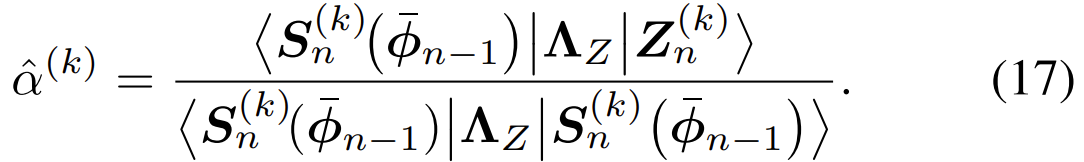

In [ ]:
Lambda_z = np.eye(3072) * (2.763854534117991e-7)**(-2)
lambda_z = csr_matrix(Lambda_z)

def alpha_hat(phi_mu_x, phi_mu_y, data_fourier):
    s_nn = generate_S_signal(phi_mu_x, phi_mu_y)
    
    # Compute conjugate transpose once
    s_nn_H = s_nn.conj().T  # Conjugate transpose
    
    return (s_nn_H @ lambda_z @ data_fourier) / (s_nn_H @ lambda_z @ s_nn)

In [ ]:
def jacobian_S(epsilon,
                        position = np.array([0, 0]),
                        tx_antennas = None, rx_antennas = None,
                        S=30e6/1e-6,T_chirp=25.66e-6, transmitPower=1, gain=1, radarCrossSection=1,
                        f_sampling=20e6, N_samples=256, N_chirps=1, c = 299792458, start_freq = 77e9):
    
    wavelength = c/start_freq
    if tx_antennas is None:
        tx_antennas = np.array(([-12*(wavelength/2), 0],
                                [-8*(wavelength/2), 0],
                                [-4*(wavelength/2), 0]))
    if rx_antennas is None:
        rx_antennas = np.array(([-(3/2)*(wavelength/2), 0],
                                [-(1/2)*(wavelength/2), 0],
                                [(1/2)*(wavelength/2), 0],
                                [(3/2)*(wavelength/2), 0]))
        
    N_vx_antennas = len(tx_antennas) * len(rx_antennas)
    x, y = epsilon
    x_r, y_r = position

    ## related to path loss
    A = np.sqrt(transmitPower * gain * radarCrossSection * wavelength**2 / (4 * np.pi)**3)

    ## related to steering matrix
    ds = np.arange(0, N_vx_antennas * wavelength/2, wavelength/2)

    ## related to sinc fnc
    freqs = np.linspace(0, 2 * np.pi, N_samples)[np.newaxis]

    def path_loss(x, y):
        """path loss"""
        r = np.sqrt((x - x_r)**2 + (y - y_r)**2)
        alpha = A/r**2
        return alpha

    def partial_path_loss(x, y, x__R, y__R):
        """path loss alpha partial differentiated w.r.t first entry (works for x/y)"""
        r = np.sqrt((x - x__R)**2 + (y - y__R)**2)
        partial_alpha = - 2 * A * r**(-4) * (x - x__R)
        return partial_alpha

    def steering_matrix(x, y):
        """steering matrix"""
        deltaR = np.sin(-np.atan2(x - x_r, y - y_r)) * ds
        phi = 2 * np.pi * deltaR / wavelength
        steering_mat = np.exp(1.j * 2 * np.pi * phi)
        return steering_mat[:, np.newaxis]

    def partial_steering_matrix(x, y, x__R, y__R, x_partial=True):
        """steering matrix partial differentiated w.r.t x/y"""
        exp1 = 1 + (x - x__R)**2/(y - y__R)**2
        partial_deltaR = (-(1/((y - y__R) * np.sqrt(exp1))) + (x - x__R)**2/((y - y__R)**3 * exp1**(3/2))) * ds
        
        if not x_partial:
            partial_deltaR = ((x - x__R)/((y - y__R)**2 * np.sqrt(exp1)) - ((x - x__R)**3/((y - y__R)**4 * exp1**(3/2)))) * ds

        partial_phi_deltaR = 2 * np.pi/wavelength

        deltaR = np.sin(-np.atan2(x, y)) * ds
        phi = 2 * np.pi * deltaR / wavelength
        partial_a_phi = 1.j * 2 * np.pi * np.exp(1.j * 2 * np.pi * phi)
        partial_steering_mat = partial_a_phi * partial_phi_deltaR * partial_deltaR
        return partial_steering_mat[:, np.newaxis]
        
    def sinc(x, y):
        """sinc function"""
        r = np.sqrt((x - x_r)**2 + (y - y_r)**2)
        f_IF = (2 * S * r / c) * (2 * np.pi / f_sampling)
        K = np.exp(-1.j * freqs * N_samples/2)

        sinc_fnc = K * np.sin((freqs - f_IF) * (N_samples + 1) * 1/2)/np.sin((freqs - f_IF)/2)
        return sinc_fnc
    
    def partial_sinc(x, y, x__R, y__R):
        """sinc fnc (fourier transform of window fnc) partially differentiated w.r.t. first entry"""
        r = np.sqrt((x - x__R)**2 + (y - y__R)**2)
        K = np.exp(-1.j * freqs * N_samples/2)

        # from Maple:
        partial_sinc = (K * S * ((x - x__R) ** 2 + (y - y__R) ** 2) ** (-0.1e1 / 0.2e1) / c * (2 * x - 2 * x__R) * (N_samples + 1) 
                        * np.cos((freqs - 2 * S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c) * (N_samples + 1) / 2) 
                        / np.sin(-freqs / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c) / 2 + K 
                        * np.sin((freqs - 2 * S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c) * (N_samples + 1) / 2) 
                        / np.sin(-freqs / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c) ** 2 * S 
                        * ((x - x__R) ** 2 + (y - y__R) ** 2) ** (-0.1e1 / 0.2e1) / c * (2 * x - 2 * x__R) 
                        * np.cos(-freqs / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c) / 2)
        return partial_sinc


    S_tilde = steering_matrix(x, y) @ sinc(x, y)
    partial_S_tilde_x = partial_steering_matrix(x, y, x_r, y_r, x_partial=True) @ sinc(x, y) + steering_matrix(x, y) @ partial_sinc(x, y, x_r, y_r)
    S_jacobian_x = np.reshape(partial_S_tilde_x * path_loss(x, y) + S_tilde * partial_path_loss(x, y, x_r, y_r), [N_vx_antennas * N_samples])[:, np.newaxis]

    partial_S_tilde_y = partial_steering_matrix(x, y, x_r, y_r, x_partial=False) @ sinc(x, y) + steering_matrix(x, y) @ partial_sinc(y, x, y_r, x_r)
    S_jacobian_y = np.reshape(partial_S_tilde_y * path_loss(x, y) + S_tilde * partial_path_loss(y, x, y_r, x_r), [N_vx_antennas * N_samples])[:, np.newaxis]

    S_jacobian = np.hstack((S_jacobian_x, S_jacobian_y))
    return np.flip(S_jacobian)

def jacobian_S(epsilon,
                        position = np.array([0, 0]),
                        tx_antennas = None, rx_antennas = None,
                        S=30e6/1e-6,T_chirp=25.66e-6, transmitPower=1, gain=1, radarCrossSection=1,
                        f_sampling=20e6, N_samples=256, N_chirps=1, c = 299792458, start_freq = 77e9):
    
    wavelength = c/start_freq
    if tx_antennas is None:
        tx_antennas = np.array(([-12*(wavelength/2), 0],
                                [-8*(wavelength/2), 0],
                                [-4*(wavelength/2), 0]))
    if rx_antennas is None:
        rx_antennas = np.array(([-(3/2)*(wavelength/2), 0],
                                [-(1/2)*(wavelength/2), 0],
                                [(1/2)*(wavelength/2), 0],
                                [(3/2)*(wavelength/2), 0]))
    x, y = epsilon
    x_r, y_r = position

    def maple(x, y, x_R, y_R, x_TX, y_TX, x_RX, y_RX):
        freqs = 0
        ## related to sinc fnc
        freqs = np.linspace(0, 2 * np.pi, N_samples)[np.newaxis]

        K = np.exp(-1.j * freqs * N_samples/2)
        j = 1.j
        f = freqs
        slope = S
        lambda_c = c / start_freq
        Gain = gain
        transmit_power = transmitPower
        rcs = radarCrossSection

        t1 = x - x_R
        t2 = t1 ** 2
        t4 = (y - y_R) ** 2
        t5 = t2 + t4
        t6 = np.sqrt(t5)
        t8 = 0.1e1 / t6 * slope
        t9 = 0.1e1 / c
        t10 = 0.1e1 / f_sampling
        t14 = N_samples + 1
        t18 = t10 * np.pi * t9 * t6 * slope
        t22 = t14 * (f - 4 * t18) / 2
        t23 = np.cos(t22)
        t27 = f / 2 - 2 * t18
        t28 = np.sin(t27)
        t29 = 0.1e1 / t28
        t34 = np.exp(-j * f * N_samples / 2)
        t36 = x - x_TX
        t37 = t36 ** 2
        t39 = (y - y_TX) ** 2
        t41 = np.sqrt(t37 + t39)
        t42 = x - x_RX
        t43 = t42 ** 2
        t45 = (y - y_RX) ** 2
        t47 = np.sqrt(t43 + t45)
        t49 = 0.1e1 / lambda_c
        t53 = np.exp(2 * t49 * (t41 + t47) * j * np.pi)
        t56 = lambda_c ** 2
        t57 = t56 * Gain * transmit_power
        t60 = t5 ** 2
        t64 = np.sqrt(0.1e1 / t60 / np.pi * rcs * t57)
        t65 = t64 * t53 * t34
        t69 = np.sin(t22)
        t70 = t28 ** 2
        t76 = np.cos(t27)
        t81 = t29 * t69
        t95 = np.pi ** 2
        t108 = -t65 * t29 * t23 * t14 * t1 * t10 * t9 * t8 / 4 + t76 * t1 * t10 * t9 * t8 * t65 / t70 * t69 / 4 + t64 * t53 * t49 * (2 * t36 / t41 + 2 * t42 / t47) * j * t34 * t81 / 8 - t1 / t5 / t60 * rcs * t57 / t64 / t95 * t53 * t34 * t81 / 4

        res = t108

        return res
    
    S_jacobian = np.zeros((len(tx_antennas)*len(rx_antennas)*N_samples, 2))
    print(S_jacobian.shape)

    for i in range(0, len(tx_antennas)):
        for j in range(0, len(rx_antennas)):
            x_TX = tx_antennas[i,0]
            y_TX = tx_antennas[i,1]
            x_RX = rx_antennas[j,0]
            y_RX = rx_antennas[j,1]
            
            S_jacobian_col_1 = maple(x, y, x_r, y_r, x_TX, y_TX, x_RX, y_RX).T
            S_jacobian_col_2 = maple(y, x, x_r, y_r, x_TX, y_TX, x_RX, y_RX).T
            S_jacobian_temp = np.hstack((S_jacobian_col_1, S_jacobian_col_2))
            print(S_jacobian_temp.shape)
            S_jacobian[N_samples*(i*len(rx_antennas) + j):N_samples*(i*len(rx_antennas) + j + 1),:] = S_jacobian_temp
    
    return S_jacobian

5.500791692706784 5.501
8.999754015519597e-10
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)


C:\Users\rasmu\AppData\Local\Temp\ipykernel_23676\2272142817.py:190: ComplexWarning: Casting complex values to real discards the imaginary part
  S_jacobian[N_samples*(i*len(rx_antennas) + j):N_samples*(i*len(rx_antennas) + j + 1),:] = S_jacobian_temp


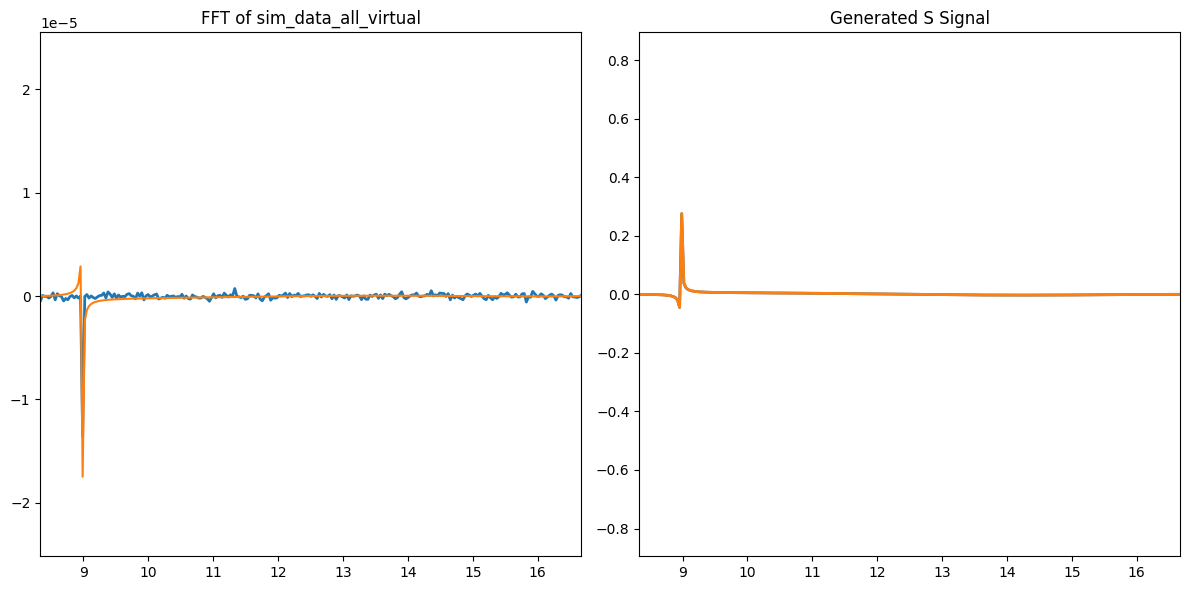

In [ ]:
frame = 1

print(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])
sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]
max_range = 100
Ns = 3072


# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual
data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])
data_fourier_energy = data_fourier.conj().T @ data_fourier
data_fourier = np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier
S_N = generate_S_signal(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])/np.sqrt(256)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(np.linspace(0, max_range, Ns), np.real(data_fourier.T), lw=2)
axs[0].plot(np.linspace(0, max_range, Ns), np.real(S_N))
print(np.min(np.abs(S_N)))
XLIM = [100/12, 200/12]
axs[0].set_xlim(XLIM)
axs[0].set_title('FFT of sim_data_all_virtual')
axs[1].set_xlim(XLIM)
axs[1].set_title('Generated S Signal')
axs[1].plot(np.linspace(0, max_range, Ns), np.real(jacobian_S(np.array([[5.5],[5.5]]))), lw=2)
plt.tight_layout()
plt.show()

In [ ]:
np.abs(alpha_hat(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame], data_fourier.T))

array([[0.05962962]])

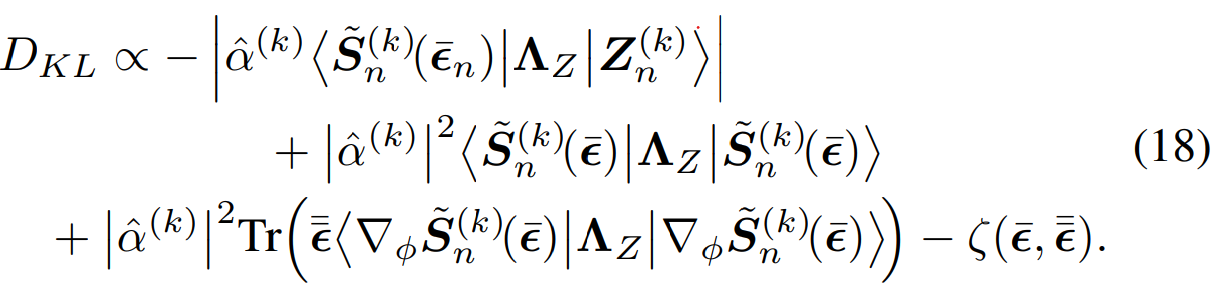

In [ ]:
#Lambda_z = np.eye(3072) * (Boltzmann * 290 * 0.77e9)**(-2)
Lambda_z = np.eye(3072) * (2.763854534117991e-7)**(-2)
Lambda_z = csr_matrix(Lambda_z)

def D_KL(params, Z_data, phi_bar_last_x, phi_bar_last_y):
    eps_bar_x, eps_bar_y, eps_barbar_0, eps_barbar_1 = params
    #eps_bar_x, eps_bar_y = params
    #eps_barbar_0, eps_barbar_1 = 1, 1

    alpha_hat_xy = 1 #alpha_hat(phi_bar_last_x, phi_bar_last_y, Z_data)
    #print(np.abs(alpha_hat_xy))
    
    s_n = generate_S_signal(eps_bar_x, eps_bar_y)

    term_1 = -np.abs(alpha_hat_xy * (s_n.conj().T @ Lambda_z @ Z_data))
    term_2 = np.abs(np.abs(alpha_hat_xy)**2 * s_n.conj().T @ Lambda_z @ s_n)
    
    jac = jacobian_S(np.array([eps_bar_x, eps_bar_y]))
    term_3_inner_prod = (jac.conj().T @ Lambda_z @ jac)
    
    term_3 = np.abs(alpha_hat_xy)**2 * np.trace(np.array([[eps_barbar_0, 0], [0, eps_barbar_1]]) * term_3_inner_prod)
    k = 2
    entropy = k/2 * np.log(2*np.pi*np.e) + 1/2*np.log(eps_barbar_0 * eps_barbar_1)

    #print(term_1, term_2, term_3, entropy)
    
    return term_1 + term_2 + term_3*1e-3 - entropy

In [ ]:
frame = 40

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

#data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

In [ ]:
"""
bounds = [(5,50), (5,50), (0.001, 100), (0.001, 100)]

result = differential_evolution(D_KL, bounds, args=(data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[1][frame-1]),
                                strategy='best1bin', 
                                maxiter=5000, 
                                popsize=50, 
                                tol=1e-9, 
                                mutation=(0.5, 1.0), 
                                recombination=0.7)
"""

"\nbounds = [(5,50), (5,50), (0.001, 100), (0.001, 100)]\n\nresult = differential_evolution(D_KL, bounds, args=(data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[1][frame-1]),\n                                strategy='best1bin', \n                                maxiter=5000, \n                                popsize=50, \n                                tol=1e-9, \n                                mutation=(0.5, 1.0), \n                                recombination=0.7)\n"

In [ ]:
last_frame_x = target_model_1.get_trajectory()[0][frame-1]
last_frame_y = target_model_1.get_trajectory()[1][frame-1]
print(last_frame_x, last_frame_y)
bnds = [(5,50), (5,50), (0.001, 100), (0.001, 100)]

result = minimize(D_KL, (last_frame_x, last_frame_y, 0.3, 0.1), bounds=bnds, args=(data_fourier, last_frame_x, last_frame_y), method="Nelder-Mead")

14.290597150038693 24.501
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(2

C:\Users\rasmu\AppData\Local\Temp\ipykernel_23676\2272142817.py:190: ComplexWarning: Casting complex values to real discards the imaginary part
  S_jacobian[N_samples*(i*len(rx_antennas) + j):N_samples*(i*len(rx_antennas) + j + 1),:] = S_jacobian_temp


(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)


In [ ]:
print(f"{result.x}\n{target_ground_truth[0][frame], target_ground_truth[1][frame]}")

[5.e+00 5.e+01 1.e-03 1.e-03]
(np.float64(14.093974268256819), np.float64(25.001))


In [ ]:
np.sqrt(result.x[2]), np.sqrt(result.x[3])

(np.float64(0.03162277660168379), np.float64(0.03162277660168379))

In [ ]:
D_KL_search_space = np.linspace(0.01, 10, 100)

# Use parallel processing to speed up the nested loop
results = Parallel(n_jobs=-1)(
    delayed(D_KL)(
        np.array([target_ground_truth[0][frame], target_ground_truth[1][frame], i, j]),
        data_fourier,
        target_model_1.get_trajectory()[0][frame-1],
        target_model_1.get_trajectory()[0][frame-1]
    )
    for i in D_KL_search_space
    for j in D_KL_search_space
)

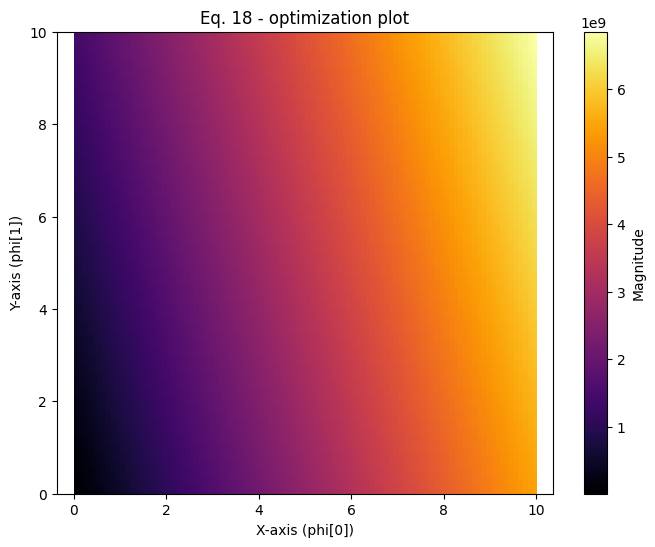

In [ ]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

gridsize = 100

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(results).reshape(gridsize, gridsize)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, origin='lower', extent=[0, 10, 0, 10], cmap='inferno', aspect='auto')
#min_index = np.argmin(heatmap)
#min_index_2d = np.unravel_index(min_index, heatmap.shape)
#plt.scatter(min_index_2d[1]/gridsize, min_index_2d[0]/gridsize, marker='x', color='red', s=100)
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [ ]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)

print(f"Minimum value at index: {min_index_2d}")

Minimum value at index: (np.int64(0), np.int64(0))


In [ ]:
gridsize = 100

# Define the range for phi[0] and phi[1]
x_values = np.linspace(0.0001, 50.0001, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(0.0001, 50.0001, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [result.x[2]], [result.x[3]]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (10000, 4, 1)


In [ ]:
S_signals = Parallel(n_jobs=-1)(delayed(D_KL)(phis[n][:4].flatten(), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1]) for n in tqdm(range(len(phis))))

100%|██████████| 10000/10000 [00:08<00:00, 1225.11it/s]


(100, 50)


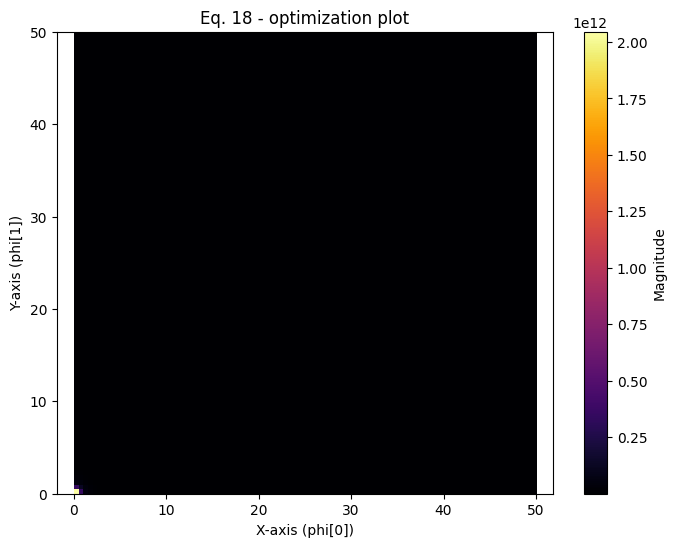

In [ ]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(S_signals).reshape(gridsize, gridsize)
print(heatmap[:100,:50].shape)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap[1:,1:], origin='lower', extent=[0, 50, 0, 50], cmap='inferno', aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [ ]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")

Minimum value at index: (np.int64(4), np.int64(97))
x: 48.98999898989899, y: 2.0203020202020205


In [ ]:
delta_t = 0.1

T = np.array([[1, 0, delta_t, 0],
            [0, 1, 0, delta_t],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])

mu_a = np.array([[0],
                [0],
                [0],
                [0]])

G = np.diagflat([(delta_t**2)/2,(delta_t**2)/2,delta_t,delta_t])

G_inv = np.linalg.inv(G)

phi = np.array([[10],
                    [10],
                    [0],
                    [0]])

In [ ]:
def broadcast_parameters(n, phi_bar_last_x_, phi_bar_last_y_):
    """
    Each radar computes eps_bar and eps_barbar and broadcasts them.
    """
    # FOR LOOP HERE FOR MULTIPLE RADARS
    sim_data_all_virtual = sim_data[n,:,:,0,:].flatten()[:, np.newaxis]
    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T



    #S_signals = Parallel(n_jobs=-1)(delayed(D_KL)(phis[n][:2].flatten(), data_fourier) for n in range(len(phis)))

    # Find the index of the minimum value in S_signals
    #min_index = np.argmin(S_signals)

    # Convert the flat index to 2D index
    #min_index_2d = np.unravel_index(min_index, (gridsize, gridsize))

    # Get the corresponding x and y values
    #epsbar_x = x_values[min_index_2d[1]]
    #epsbar_y = y_values[min_index_2d[0]]

    bounds = [(5,90), (5,90), (0.001, 100), (0.001, 100)]

    #bounds1 = [(0.1,10), (0.1,10), (0.1,10), (0.1,10)]

    result = minimize(D_KL, (phi_bar_last_x_, phi_bar_last_y_, 1, 1), args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_), method="Nelder-Mead")

    #result = differential_evolution(D_KL, bounds, args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_))

    #result1 = differential_evolution(D_KL3_entropy, bounds1, args=(phi_bar_last_x_, phi_bar_last_y_, result.x[0], result.x[1]))

    return np.array([[result.x[0]], [result.x[1]], [result.x[2]], [result.x[3]]])


def message_passing(N_iter = 100, N = 30):
    eps_bar_list = []
    eps_barbar_list = []

    phi_bar_list = [np.array([[10], [10], [0], [0]])]
    phi_eq18 = [np.array([[10], [10], [0], [0]])]
    phi_barbar_list = [np.array([[0.1,0,0,0], [0,0.1,0,0], [0,0,10,0], [0,0,0,10]])]

    Lambda_a = np.diagflat([0.1,0.1,0.1,0.1])


    for n in tqdm(range(N)):
        D_KL = broadcast_parameters(n+1, phi_bar_list[n][0, 0], phi_bar_list[n][1, 0])
        eps_bar = D_KL[:2]
        eps_bar = np.vstack((eps_bar, np.array([[0.000], [0.000]])))
        eps_bar_list.append(eps_bar)
        phi_eq18.append(eps_bar_list[n])
        eps_barbar_list.append(np.array([[D_KL[2][0],0,0,0], [0,D_KL[3][0],0,0], [0,0,1e20,0], [0,0,0,1e20]])) # np.array([[D_KL[2][0],0,0,0], [0,D_KL[3][0],0,0], [0,0,1e20,0], [0,0,0,1e20]])

        beta = np.zeros((4,4))
        alpha = n+1

        for _ in range(N_iter):
            for i in range(len(phi_bar_list)):
                if i-n == 0:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) * np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i]
                else:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G + T.T@G_inv.T@Lambda_a@G_inv@T
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) * np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i] + (T.T@G_inv.T@Lambda_a@G_inv@T)@np.linalg.inv(T)@phi_bar_list[i+1]
                    
                if n > 0:
                    beta += np.linalg.norm(np.linalg.inv(G)@(phi_bar-T@phi_bar_list[i]))**2 + G_inv@(np.linalg.inv(phi_bar_bar_inv)+T@phi_barbar_list[i]@T.T)@G_inv.T
        
        if n > 0:
            Lambda_a = np.linalg.inv(beta/alpha)
        
        phi_bar_list.append(phi_bar)
        phi_barbar_list.append(np.linalg.inv(phi_bar_bar_inv))

        
    
    return phi_bar_list, phi_barbar_list, phi_eq18

In [ ]:
mrblat_data, mrblat_data_phibarbar, eq18 = message_passing()

  0%|          | 0/30 [00:00<?, ?it/s]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

C:\Users\rasmu\AppData\Local\Temp\ipykernel_23676\2272142817.py:190: ComplexWarning: Casting complex values to real discards the imaginary part
  S_jacobian[N_samples*(i*len(rx_antennas) + j):N_samples*(i*len(rx_antennas) + j + 1),:] = S_jacobian_temp
C:\Users\rasmu\AppData\Local\Temp\ipykernel_23676\839354129.py:23: RuntimeWarning: invalid value encountered in log
  entropy = k/2 * np.log(2*np.pi*np.e) + 1/2*np.log(eps_barbar_0 * eps_barbar_1)


(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

  3%|▎         | 1/30 [00:02<01:24,  2.91s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

  7%|▋         | 2/30 [00:05<01:21,  2.90s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 10%|█         | 3/30 [00:08<01:18,  2.89s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 13%|█▎        | 4/30 [00:11<01:15,  2.91s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 17%|█▋        | 5/30 [00:14<01:12,  2.91s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 20%|██        | 6/30 [00:17<01:10,  2.93s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 23%|██▎       | 7/30 [00:20<01:07,  2.94s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 27%|██▋       | 8/30 [00:23<01:04,  2.93s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 30%|███       | 9/30 [00:26<01:01,  2.92s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 33%|███▎      | 10/30 [00:29<00:58,  2.91s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 37%|███▋      | 11/30 [00:32<00:55,  2.92s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 40%|████      | 12/30 [00:34<00:52,  2.91s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 43%|████▎     | 13/30 [00:37<00:49,  2.90s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 47%|████▋     | 14/30 [00:40<00:46,  2.91s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 50%|█████     | 15/30 [00:43<00:43,  2.92s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 53%|█████▎    | 16/30 [00:46<00:38,  2.78s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 57%|█████▋    | 17/30 [00:49<00:36,  2.82s/it]

(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(2

 60%|██████    | 18/30 [00:52<00:34,  2.87s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 63%|██████▎   | 19/30 [00:55<00:31,  2.89s/it]

(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(2

 67%|██████▋   | 20/30 [00:57<00:27,  2.75s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 70%|███████   | 21/30 [01:00<00:25,  2.84s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 73%|███████▎  | 22/30 [01:03<00:23,  2.88s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 77%|███████▋  | 23/30 [01:06<00:20,  2.93s/it]

(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

 80%|████████  | 24/30 [01:09<00:17,  2.90s/it]


(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(3072, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(256, 2)
(

KeyboardInterrupt: 

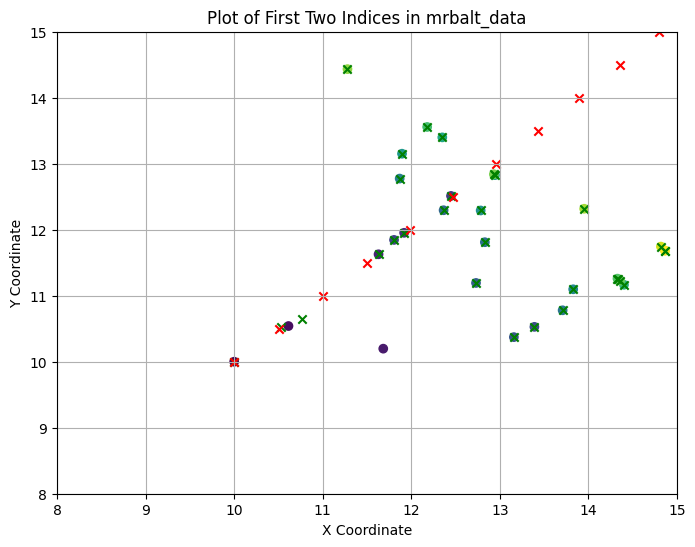

In [ ]:
# Extract the first two indices from mrbalt_data
x_coords = [data[0, 0] for data in mrblat_data]
y_coords = [data[1, 0] for data in mrblat_data]

x_coords1 = [data[0, 0] for data in eq18]
y_coords1 = [data[1, 0] for data in eq18]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords,c=np.linspace(0, 1, len(x_coords)), cmap='viridis', marker='o')
plt.scatter(x_coords1, y_coords1, c='green', marker='x')
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x')
plt.xlim([8, 15])
plt.ylim([8, 15])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of First Two Indices in mrbalt_data')
plt.grid(True)
plt.show()

In [ ]:
mrblat_data

[array([[10],
        [10],
        [ 0],
        [ 0]]),
 array([[11.03904408],
        [11.04310978],
        [ 0.        ],
        [ 0.        ]]),
 array([[11.76224787],
        [11.72213366],
        [ 0.        ],
        [ 0.        ]]),
 array([[ 1.15304776e+01],
        [ 1.15726498e+01],
        [-2.62408855e-07],
        [-2.61446127e-07]]),
 array([[ 1.21584519e+01],
        [ 1.22045910e+01],
        [-2.20639767e-11],
        [-2.26033418e-11]]),
 array([[ 1.24498630e+01],
        [ 1.25173163e+01],
        [-1.54677746e-14],
        [-1.64865275e-14]]),
 array([[ 1.25406839e+01],
        [ 1.22044314e+01],
        [-7.81617534e-18],
        [-8.55904482e-18]]),
 array([[ 1.23356220e+01],
        [ 1.23059449e+01],
        [-5.96888065e-21],
        [-3.77231319e-21]]),
 array([[ 1.27251296e+01],
        [ 1.15089394e+01],
        [-5.62014577e-24],
        [-5.48192139e-24]]),
 array([[ 1.29485910e+01],
        [ 1.19021032e+01],
        [-2.46257413e-24],
        [-2.2

In [ ]:
results = np.zeros((100, 4))

bounds = [(5,90), (5,90), (0.001, 100), (0.001, 100)]

results[0] = np.array(([10, 10, 0, 0]))  # Initialize results as a list of lists

for n in tqdm(range(10)):
    # FOR LOOP HERE FOR MULTIPLE RADARS
    sim_data_all_virtual = sim_data[n+1,:,:,0,:].flatten()[:, np.newaxis]
    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T
    
    if n == 0:
        #bounds = [(0,25), (0,90)]
        result = minimize(D_KL, (results[0][0], results[0][1], 10, 10), args=(data_fourier, results[0][0], results[0][1]), method="Nelder-Mead")
    else:
        #bounds = [(results[n-1, 0]-10,results[n-1, 0]+10), (results[n-1, 0]-10,results[n-1, 0]+10)]
        #print(bounds)
        result = minimize(D_KL, (results[n][0], results[n][1], results[n][2], results[n][3]), args=(data_fourier, results[0][0], results[0][1]), method="Nelder-Mead")

    results[n+1] = result.x.tolist()  # Insert the result at the correct index

100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


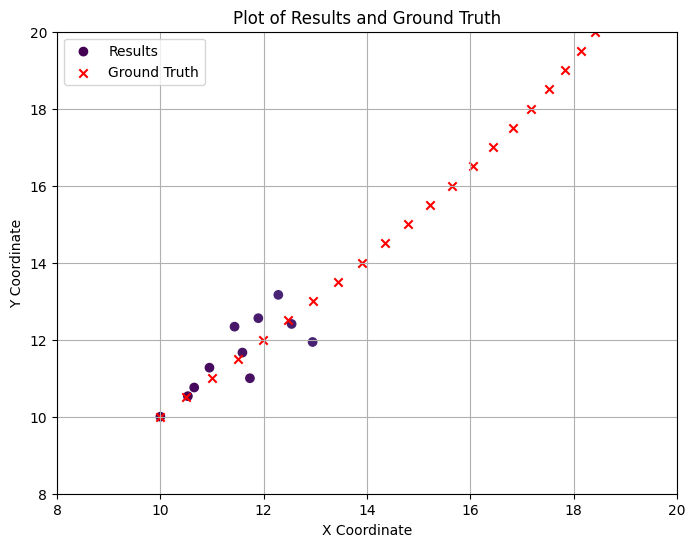

In [ ]:
# Extract the first two indices from results
x_results = [result[0] for result in results]
y_results = [result[1] for result in results]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_results, y_results, c=np.linspace(0, 1, len(x_results)), cmap='viridis', marker='o', label='Results')
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x', label='Ground Truth')
plt.xlim([8, 20])
plt.ylim([8, 20])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of Results and Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
results

array([[ 1.00000000e+01,  1.00000000e+01,  0.00000000e+00,
         0.00000000e+00],
       [ 1.05323854e+01,  1.05340035e+01,  9.82845307e-01,
         9.77573139e-01],
       [ 9.73736953e+00,  9.89038089e+00, -7.30319578e-04,
         7.71916473e-04],
       [ 1.04820658e+01,  1.06506733e+01,  1.01515699e+00,
         9.85376508e-01],
       [ 9.72326825e+00,  1.06819926e+01, -7.33610663e-04,
         7.57089147e-04],
       [ 1.08727228e+01,  1.07140031e+01,  9.98367946e-01,
         9.96371936e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
      